In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

In [209]:
cmap_bold = ListedColormap(["#FF0000","#00FF00","#0000FF"])
cmap_light = ListedColormap(["#FFBBBB","#BBFFBB","#BBBBFF"])

**Useful Functions**

In [210]:
def ReLU(H):
  return H*(H>0)

def softmax(H):
  eH = np.exp(H)
  return eH/eH.sum(axis=1, keepdims = True)

def cross_entropy(Y, P_hat):
  return -np.sum(Y*np.log(P_hat))

def one_hot_encode(y):
  N = len(y)
  K = len(set(y))
  Y = np.zeros((N,K))

  for i in range (N):
    Y[i, y[i]]=1
  return Y

def accuracy (y, y_hat):
  return np.mean (y==y_hat)

def linear(H):
  return H

def sigmoid(H):
  return (1/(1+np.exp(-H)))

def OLS(Y, Y_hat):
  return (1/(2*len(Y)))*np.sum((Y-Y_hat)**2)

def R2(y,y_hat):
  return 1 - np.sum((y-y_hat)**2)/np.sum((y-y.mean())**2)

# Derivatives

def derivative (Z, a):

  if a==linear:
    return 1

  elif a==sigmoid:
    return Z*(1-Z)

  elif a==np.tanh:
    return 1-Z*Z

  elif a==ReLU:
    return (Z>0).astype(int)

  else:
    ValueError("Unknown Activation Funtion")
    

In [211]:
class Shallow_ANN():

  def fit(self,X,y, neurons=10, eta=1e-3, epochs =1e3, show_curve=False):
    epochs=int(epochs)
    Y= one_hot_encode(y)
    N,D=X.shape

    K=Y.shape[1]

    #Initialize Weights and Biases

    self.W = {l: np.random.randn(M[0],M[1]) for l , M in enumerate(zip([D,neurons], [neurons, K]),1)}
    self.b = {l: np.random.randn(M) for l , M in enumerate([neurons, K],1)}

    self.a = {1: np.tanh, 2:softmax}

    J= np.zeros(epochs)

    for epoch in range(epochs):
      self.__forward__(X)
      P_hat = self.Z[2]
      J[epoch] = cross_entropy(Y, P_hat)

      self.W[2] -= eta*(1/N)*self.Z[1].T@(P_hat-Y)
      self.b[2] -= eta*(1/N)*(P_hat-Y).sum(axis=0)

      self.W[1] -= eta*(1/N)*X.T@((P_hat-Y)@self.W[2].T*(1-self.Z[1]**2))
      self.b[1] -= eta*(1/N)*((P_hat-Y)@self.W[2].T*(1-self.Z[1]**2)).sum(axis = 0)

    if show_curve:
      plt.figure()
      plt.plot(J)
      plt.xlabel("epochs")
      plt.ylabel("$\mathcal{J}$")
      plt.show()

  def __forward__(self, X):
    self.Z ={0:X}

    for l in sorted(self.W.keys()):
      self.Z[l]=self.a[l](self.Z[l-1]@self.W[l]+self.b[l])
  
  def predict(self, X):
    self.__forward__(X)
    return self.Z[2].argmax(axis=1)



In [212]:
{str(i): j for i,j in zip(range (4), range(10,14))}

{'0': 10, '1': 11, '2': 12, '3': 13}

In [213]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Enhance IT/Perceptron/TripGaussKNN.csv')
data

,Unnamed: 0,0,1,2
0,0,2.769395,0.762216,0
1,1,1.519271,1.487948,0
2,2,2.407084,2.836605,0
3,3,1.276534,1.396749,0
4,4,0.380165,4.396517,0
...,...,...,...,...
2995,2995,-3.537007,3.431588,2
2996,2996,-1.709969,2.675040,2
2997,2997,-2.098664,2.084230,2
2998,2998,-1.523310,1.083698,2


In [214]:
y = data['2'].to_numpy()

In [215]:
X = data[['0', '1']].to_numpy()

In [216]:
print (X)
print (X.shape)

[[ 2.76939496  0.76221573]
 [ 1.51927052  1.48794784]
 [ 2.40708363  2.83660528]
 ...
 [-2.09866389  2.08423019]
 [-1.52330999  1.08369811]
 [-2.87191052  0.3439586 ]]
(3000, 2)


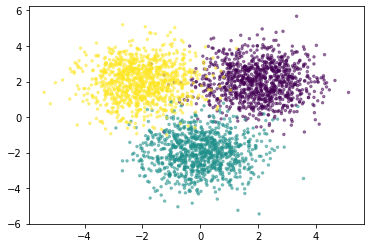

In [217]:
plt.figure()
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.5, s=6)

In [218]:
myANN = Shallow_ANN()

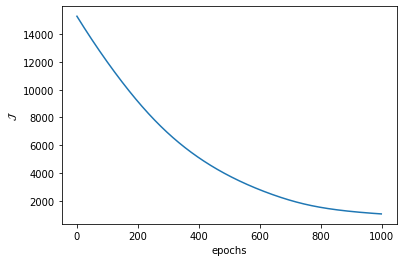

In [219]:
myANN.fit(X,y, show_curve=True)

In [220]:
y_hat=myANN.predict(X)

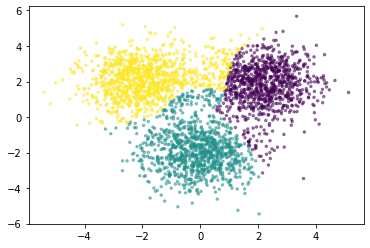

In [221]:
plt.figure()
plt.scatter(X[:,0], X[:,1], c=y_hat, alpha=0.5, s=6)

In [222]:
accuracy(y,y_hat)

0.9016666666666666

# Variable Architecture Neural Network with Back Propagation

In [223]:
class ANN():

  def __init__(self, architecture, activations = None, mode=0):
    self.mode = mode
    self.architecture = architecture
    self.activations = activations
    self.L = len(architecture)+1
  
  def fit(self, X, y, eta=1e-3, epochs=1e3, show_curve=False):
    epochs = int(epochs)

    if self.mode:
      Y=y
    
    else:
      Y = one_hot_encode(y)
    
    N, D = X.shape
    K = Y.shape[1]

    # Initialize Weights and Biases
    self.W = {l: np.random.randn(M[0],M[1]) for l, M in enumerate
              (zip(([D]+self.architecture), (self.architecture+[K])),1)}
    self.b = {l: np.random.randn(M) for l, M in enumerate(self.architecture+[K],1)}

    # Activation Function Loading
    if self.activations is None:
      self.a = {l:ReLU for l in range(1, self.L)}
    else: 
      self.a = {l:act for l, act in enumerate(self.activations, 1)}
    
    # Mode Set
    if self.mode:   #mode=1 thus Regression
      self.a[self.L] = linear
    else:           #mode=2 thus Classification
      self.a[self.L] = softmax
    
    J = np.zeros(epochs)

    # Gradient Descent / Back Propagation
    for epoch in range(epochs):
      self.forward(X)

      if self.mode:
        J[epoch] = OLS(Y, self.Z[self.L])

      else:
        J[epoch] = cross_entropy(Y, self.Z[self.L])

      dH = (1/N)*(self.Z[self.L] - Y)

      for l in sorted(self.W.keys(), reverse=True):
        dW = self.Z[l-1].T@dH
        db = dH.sum(axis=0)

        self.W[l] -= eta*dW
        self.b[l] -= eta*db

        if l>1:
          dZ = dH@self.W[l].T
          dH = dZ*derivative(self.Z[l-1], self.a[l-1])

    if show_curve:
      plt.figure()
      plt.plot(J)
      plt.xlabel("epochs")
      plt.ylabel("$\mathcal{J}$")
      plt.show()

  def forward(self, X):
    self.Z = {0:X}

    for l in sorted(self.W.keys()):
      self.Z[l] = self.a[l](self.Z[l-1]@self.W[l]+self.b[l])

  def predict(self, X):
    self.forward(X)

    if self.mode:
      return self.Z[self.L]
    
    else: 
      return self.Z[self.L].argmax(axis=1)


In [224]:
my_ann_arch = ANN([8,8,8],[ReLU, np.tanh, np.tanh])

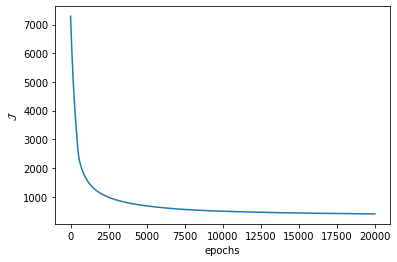

In [225]:
my_ann_arch.fit(X, y, eta=6e-4, epochs=2e4, show_curve=True)

In [226]:
y_hat=my_ann_arch.predict(X)

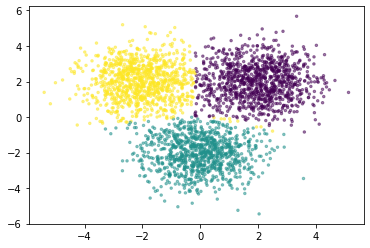

In [227]:
plt.figure()
plt.scatter(X[:,0], X[:,1], c=y_hat, alpha=0.5, s=6)

In [228]:
accuracy(y,y_hat)

0.9636666666666667

In [229]:
my_ann_arch.W

{1: array([[ 0.04045746, -0.72206676, -0.8165602 ,  0.01389052, -0.8505663 ,
          0.58150252, -0.92060079, -2.41812299],
        [ 0.30715374, -0.12086678, -2.32172122, -1.1756079 , -0.91640088,
          1.94981479,  0.09675676,  1.1668534 ]]),
 2: array([[ 1.43691397, -1.18250747, -0.71858389,  0.76624989,  2.75396007,
         -0.24739946, -0.42008203,  0.40746319],
        [ 0.50684396,  1.37570324,  1.32179182,  1.77136025, -0.25028476,
          1.29621379,  0.43385018,  0.8086146 ],
        [ 1.79107851, -0.28476873,  0.46191467,  0.85947191,  0.68818739,
         -1.66376239,  0.05551862, -1.08615514],
        [-0.50495151,  0.17173014,  1.4236584 , -1.4636868 ,  0.58588072,
         -1.55896214, -1.11422143, -0.10205757],
        [-1.46602206,  2.60396624,  0.01153004, -1.27965181,  0.06056151,
         -0.51874933,  0.57385242,  0.61497644],
        [-1.23552797,  0.24148051, -0.46284705, -0.08046566, -0.60674059,
          0.85414213, -1.59344556,  0.46229177],
        

In [230]:
def main_class():
    D = 2
    K = 3
    N = int(K*1e3)
    
    X0 = np.random.randn((N//K),D) + np.array([2,2])
    X1 = np.random.randn((N//K),D) + np.array([0,-2])
    X2 = np.random.randn((N//K),D) + np.array([-2,2])
    X = np.vstack((X0,X1,X2))
    
    y = np.array([0]*(N//K) + [1]*(N//K) + [2]*(N//K))
    
    ann = ANN([8, 8, 8], [ReLU, np.tanh, np.tanh])
    ann.fit(X, y, eta = 3e-2, epochs = 2e3, show_curve = True)
    y_hat = ann.predict(X)
    
    print(f"Training Accuracy: {accuracy(y, y_hat):0.4f}")
    
    x1 = np.linspace(X[:,0].min() - 1, X[:,0].max() + 1, 1000)
    x2 = np.linspace(X[:,1].min() - 1, X[:,1].max() + 1, 1000)
    
    xx1, xx2 = np.meshgrid(x1, x2)
    Z = ann.predict(np.c_[xx1.ravel(),xx2.ravel()]).reshape(*xx1.shape)
    
    plt.figure()
    plt.pcolormesh(xx1, xx2, Z, cmap = cmap_light)
    plt.scatter(X[:,0], X[:,1], c = y, cmap = cmap_bold,alpha=0.2)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plt.show()

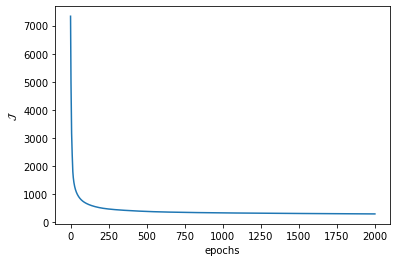

Training Accuracy: 0.9707


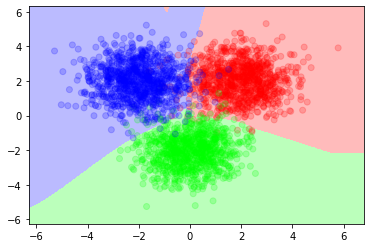

In [231]:
if __name__=="__main__":
  main_class()

In [233]:
N=200
X = np.linspace(0,15,N).reshape(N,1)
y = 3.0989 + 7.9373*np.sqrt(X) + 7.198*np.exp(-0.2*(X - 7)**2) - 11.93745*np.exp(-1.5*(X - 11)**2) + np.random.randn(N,1)*0.7

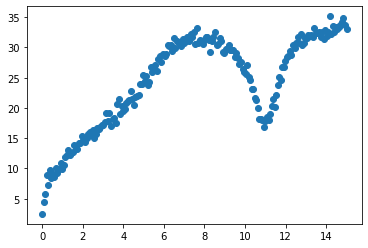

In [234]:
plt.figure()
plt.scatter(X,y)

In [235]:
ann_reg=ANN(mode=1, architecture=[12,12,12,12], activations=[np.tanh]*4)

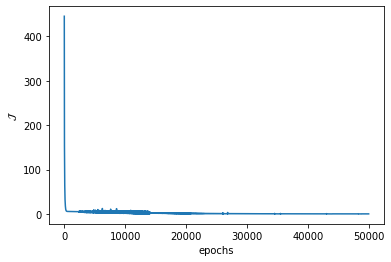

In [268]:
ann_reg.fit(X, y, eta=1e-3, epochs=5e4, show_curve=True)

In [269]:
y_hat=ann_reg.predict(X)

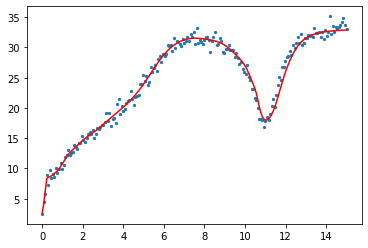

In [270]:
plt.figure()
plt.scatter(X,y, s=5)
plt.plot(X, y_hat, color="#FF0000",linewidth=1.5)

In [271]:
R2(y, y_hat)

0.9866502255647028